# Step 1: Data Understanding & Cleaning

In this step, we:
- Connect to the `.duckdb` file  
- Inspect available tables  
- Load the data into Pandas  
- Check datatypes, missing values, duplicates  
- Parse dates and engineer features  
- Prepare a clean dataset for analysis  

In [1]:
import duckdb
import pandas as pd

# Connect to the duckdb file
con = duckdb.connect("../data/warehouse.duckdb")

In [2]:
# List tables in the DuckDB file
con.execute("SHOW ALL TABLES").fetchdf()

,database,schema,name,column_names,column_types,temporary
0,warehouse,prod,sales,"[chargedate, meterid, chargedate_str, loc, res...","[DATE, BIGINT, VARCHAR, VARCHAR, VARCHAR, VARC...",False


In [3]:
df = con.execute("SELECT * FROM prod.sales").fetchdf()
df.head()

,chargedate,meterid,chargedate_str,loc,res,month,month_str,kwh,year,ghc,paymoney
0,2019-02-15,1,15-Feb-2019,Techiman [13],N-Resid [0],Feb-19,01-Feb-2019,14.2,2019,23.1705,140.0
1,2019-03-11,1,11-Mar-2019,Techiman [13],N-Resid [0],Mar-19,01-Mar-2019,57.4,2019,38.8886,40.0
2,2019-04-20,1,20-Apr-2019,Techiman [13],N-Resid [0],Apr-19,01-Apr-2019,57.4,2019,38.8886,20.0
3,2019-05-28,1,28-May-2019,Techiman [13],N-Resid [0],May-19,01-May-2019,57.4,2019,38.8886,20.0
4,2019-06-25,1,25-Jun-2019,Techiman [13],N-Resid [0],Jun-19,01-Jun-2019,57.4,2019,38.8886,20.0


In [4]:
print("Shape:", df.shape)
df.info()
df.describe()

Shape: (2867046, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867046 entries, 0 to 2867045
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   chargedate      datetime64[us]
 1   meterid         int64         
 2   chargedate_str  object        
 3   loc             object        
 4   res             object        
 5   month           object        
 6   month_str       object        
 7   kwh             float64       
 8   year            int64         
 9   ghc             float64       
 10  paymoney        float64       
dtypes: datetime64[us](1), float64(3), int64(2), object(5)
memory usage: 240.6+ MB


,chargedate,meterid,kwh,year,ghc,paymoney
count,2867046,2.867046e+06,2.806103e+06,2.867046e+06,2.867046e+06,2.827728e+06
mean,2018-02-17 20:07:38.873975,3.007559e+04,1.259905e+02,2.017648e+03,8.550323e+01,4.684029e+01
min,2012-07-17 00:00:00,1.000000e+00,1.300000e+00,2.012000e+03,3.530000e-02,0.000000e+00
25%,2016-10-17 00:00:00,9.909000e+03,5.000000e+01,2.016000e+03,1.669750e+01,1.500000e+01
50%,2018-07-23 00:00:00,3.085200e+04,8.700000e+01,2.018000e+03,3.882090e+01,3.000000e+01
75%,2019-09-25 00:00:00,4.746300e+04,1.504000e+02,2.019000e+03,7.387460e+01,5.000000e+01
max,2022-08-04 00:00:00,6.906500e+04,3.878000e+03,2.022000e+03,2.209250e+05,3.000000e+03
std,NaN,2.087392e+04,1.583007e+02,2.054593e+00,4.668627e+02,9.402291e+01


In [5]:
df_daily = con.execute("""
SELECT 
    meterid,
    chargedate::DATE as day,
    kwh,
    ghc,
    paymoney,
    loc,
    res
FROM prod.sales
""").fetchdf()
df_daily.head()

,meterid,day,kwh,ghc,paymoney,loc,res
0,1,2019-02-15,14.2,23.1705,140.0,Techiman [13],N-Resid [0]
1,1,2019-03-11,57.4,38.8886,40.0,Techiman [13],N-Resid [0]
2,1,2019-04-20,57.4,38.8886,20.0,Techiman [13],N-Resid [0]
3,1,2019-05-28,57.4,38.8886,20.0,Techiman [13],N-Resid [0]
4,1,2019-06-25,57.4,38.8886,20.0,Techiman [13],N-Resid [0]


In [6]:
df_daily['weekday'] = df_daily['day'].dt.dayofweek   # 0=Monday, 6=Sunday
df_daily['is_weekend'] = df_daily['weekday'].isin([5, 6]).astype(int)

In [7]:
# Function to report memory usage
def mem_mb(df_): 
    return df_.memory_usage(deep=True).sum() / (1024**2)

mem_before = mem_mb(df)

# Downcast numeric columns
for c in ['kwh','ghc','paymoney']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce', downcast='float')

if 'meterid' in df.columns:
    df['meterid'] = pd.to_numeric(df['meterid'], errors='coerce', downcast='integer')

# Convert object columns with few unique values into categories
for c in ['loc','res']:
    if c in df.columns and df[c].dtype == 'object':
        if df[c].nunique(dropna=True) <= 0.5 * len(df):  # heuristic
            df[c] = df[c].astype('category')

# Drop redundant string date column
if 'chargedate_str' in df.columns:
    df.drop(columns=['chargedate_str'], inplace=True)

mem_after = mem_mb(df)
print(f"Memory: {mem_before:,.1f} MB -> {mem_after:,.1f} MB ({(1 - mem_after/mem_before)*100:.1f}% saved)")
df.dtypes

Memory: 936.5 MB -> 418.3 MB (55.3% saved)


chargedate    datetime64[us]
meterid                int32
loc                 category
res                 category
month                 object
month_str             object
kwh                  float32
year                   int64
ghc                  float64
paymoney             float32
dtype: object

In [10]:
na_counts = df.isna().sum()
na_pct = (na_counts / len(df) * 100).round(2)

na_report = (
    pd.DataFrame({
        'missing_count': na_counts,
        'missing_%': na_pct
    })
    .sort_values('missing_%', ascending=False)
)

na_report

,missing_count,missing_%
kwh,60943,2.13
paymoney,39318,1.37
chargedate,0,0.00
loc,0,0.00
meterid,0,0.00
month,0,0.00
res,0,0.00
month_str,0,0.00
year,0,0.00
ghc,0,0.00


In [11]:
# 11a) Exact duplicate rows
dup_rows = df.duplicated().sum()
print("Exact duplicate rows:", dup_rows)

# 11b) Duplicates by (meterid, month_start)
if {'meterid','month_start'}.issubset(df.columns):
    dup_key = (
        df.groupby(['meterid','month_start'], as_index=False)
          .size()
          .query("size > 1")
          .sort_values('size', ascending=False)
    )
    print("Duplicate meter-month pairs:", len(dup_key))
    display(dup_key.head(10))
else:
    print("Skipped: missing key columns")


Exact duplicate rows: 0
Duplicate meter-month pairs: 0


,meterid,month_start,size


In [12]:
issues = {}

for col in ['kwh','ghc','paymoney']:
    if col in df.columns:
        issues[f'{col}_negatives'] = (df[col] < 0).sum()
        issues[f'{col}_zeros'] = (df[col] == 0).sum()

# Extreme outliers at 99.9th percentile
outlier_summary = {}
for col in ['kwh','ghc','paymoney']:
    if col in df.columns:
        q = df[col].quantile(0.999)
        outlier_summary[col] = {
            'p99_9': float(q), 
            'count_above': int((df[col] > q).sum())
        }

print("Negatives / zeros:")
print(issues)

print("\nOutlier summary (99.9th percentile):")
outlier_summary


Negatives / zeros:
{'kwh_negatives': np.int64(0), 'kwh_zeros': np.int64(0), 'ghc_negatives': np.int64(0), 'ghc_zeros': np.int64(0), 'paymoney_negatives': np.int64(0), 'paymoney_zeros': np.int64(78839)}

Outlier summary (99.9th percentile):


{'kwh': {'p99_9': 2149.800048828125, 'count_above': 2802},
 'ghc': {'p99_9': 5441.247195004284, 'count_above': 2868},
 'paymoney': {'p99_9': 1500.0, 'count_above': 1975}}

In [13]:
# Copy for cleaning
clean = df.copy()

# Drop impossible negatives (none here, but safe rule)
for col in ['kwh','ghc','paymoney']:
    clean = clean[~(clean[col] < 0)]

# Optional: if multiple rows per meter-month, aggregate to monthly
if {'meterid','month_start'}.issubset(clean.columns):
    agg_cols = {c: 'sum' for c in ['kwh','ghc','paymoney'] if c in clean.columns}
    keep_first = [c for c in ['loc','res'] if c in clean.columns]
    
    monthly = (clean
               .sort_values('chargedate')
               .groupby(['meterid','month_start'], as_index=False)
               .agg({**agg_cols, **{k:'first' for k in keep_first}}))
else:
    monthly = clean  # fallback

print("Raw shape:", df.shape)
print("Clean shape:", clean.shape)
print("Monthly shape:", monthly.shape)

monthly.head()


Raw shape: (2867046, 11)
Clean shape: (2867046, 11)
Monthly shape: (2867046, 7)


,meterid,month_start,kwh,ghc,paymoney,loc,res
0,1,2019-02-01,14.200000,23.1705,140.0,Techiman [13],N-Resid [0]
1,1,2019-03-01,57.400002,38.8886,40.0,Techiman [13],N-Resid [0]
2,1,2019-04-01,57.400002,38.8886,20.0,Techiman [13],N-Resid [0]
3,1,2019-05-01,57.400002,38.8886,20.0,Techiman [13],N-Resid [0]
4,1,2019-06-01,57.400002,38.8886,20.0,Techiman [13],N-Resid [0]


In [14]:
summary = {
    "rows_raw": len(df),
    "rows_clean": len(clean),
    "rows_monthly": len(monthly),
    "meters": monthly['meterid'].nunique(),
    "date_min": monthly['month_start'].min(),
    "date_max": monthly['month_start'].max(),
    "kwh_total": monthly['kwh'].sum(),
    "paymoney_total": monthly['paymoney'].sum()
}
summary


{'rows_raw': 2867046,
 'rows_clean': 2867046,
 'rows_monthly': 2867046,
 'meters': 69065,
 'date_min': Timestamp('2012-07-01 00:00:00'),
 'date_max': Timestamp('2022-08-01 00:00:00'),
 'kwh_total': np.float32(3.535424e+08),
 'paymoney_total': np.float32(1.3245161e+08)}

# Step 2: Exploratory Data Analysis (EDA)

In this step we:
- Explore consumption & payments over time
- Check seasonality & yearly patterns
- Look at customer distribution
- Study correlations between variables


C:\Users\Asus\AppData\Local\Temp\ipykernel_7084\908863572.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly.set_index('month_start')['kwh'].resample('M').sum().plot(figsize=(12,5))


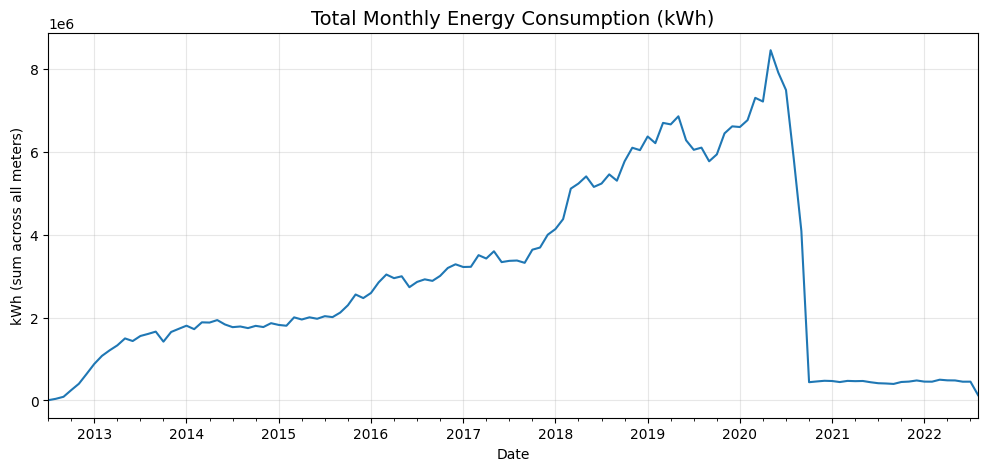

In [15]:
import matplotlib.pyplot as plt

monthly.set_index('month_start')['kwh'].resample('M').sum().plot(figsize=(12,5))
plt.title("Total Monthly Energy Consumption (kWh)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("kWh (sum across all meters)")
plt.grid(True, alpha=0.3)
plt.show()

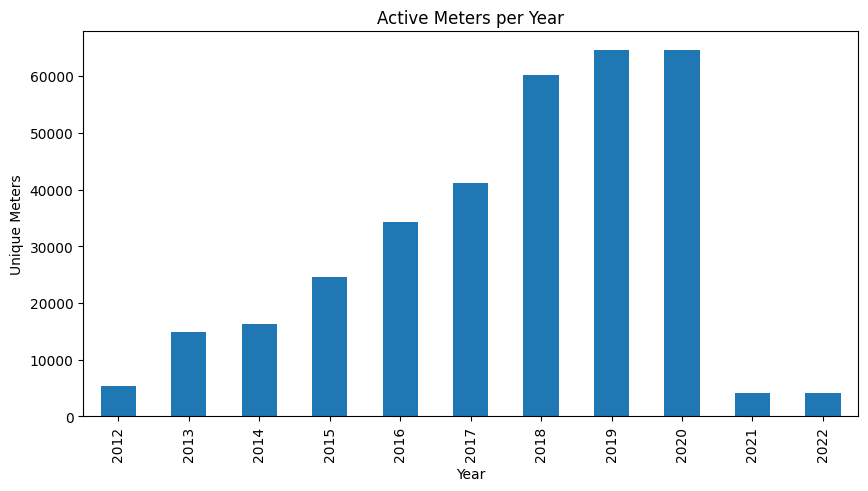

month_start
2012     5334
2013    14967
2014    16273
2015    24593
2016    34244
2017    41098
2018    60212
2019    64524
2020    64639
2021     4184
2022     4143
Name: meterid, dtype: int64

In [16]:
active_meters_per_year = (
    monthly.groupby(monthly['month_start'].dt.year)['meterid'].nunique()
)

active_meters_per_year.plot(kind='bar', figsize=(10,5))
plt.title("Active Meters per Year")
plt.xlabel("Year")
plt.ylabel("Unique Meters")
plt.show()

active_meters_per_year


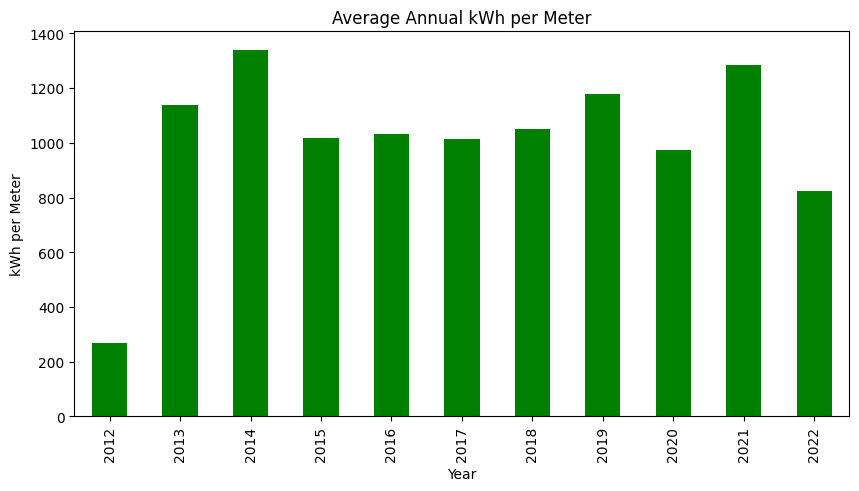

month_start
2012     268.160522
2013    1139.633423
2014    1339.987915
2015    1018.930420
2016    1031.596313
2017    1015.006104
2018    1051.652832
2019    1177.752197
2020     975.316711
2021    1285.058838
2022     824.208862
dtype: float32

In [17]:
avg_kwh_per_meter = (
    monthly.groupby(monthly['month_start'].dt.year)
    .apply(lambda g: g['kwh'].sum() / g['meterid'].nunique())
)

avg_kwh_per_meter.plot(kind='bar', figsize=(10,5), color='green')
plt.title("Average Annual kWh per Meter")
plt.xlabel("Year")
plt.ylabel("kWh per Meter")
plt.show()

avg_kwh_per_meter


C:\Users\Asus\AppData\Local\Temp\ipykernel_7084\1891569689.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  eda_df_short.set_index('month_start')['paymoney'].resample('M').sum().plot(


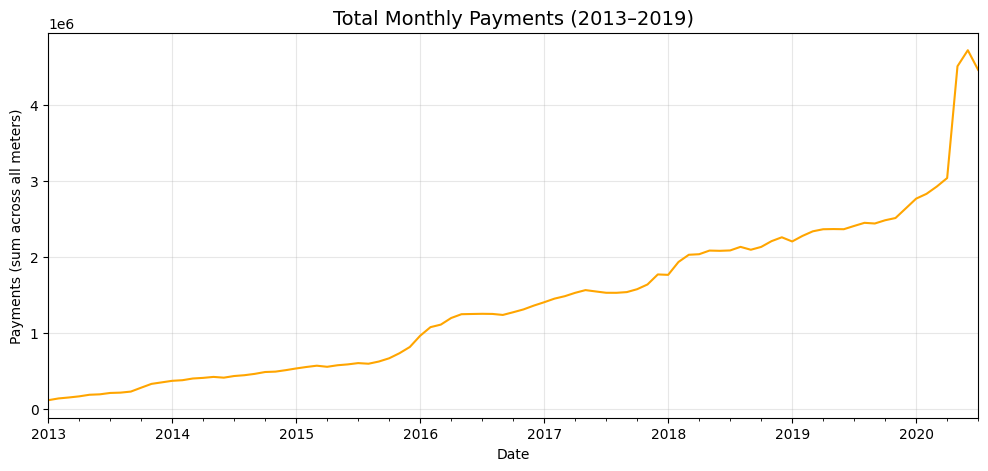

In [26]:
eda_df_short = monthly[
    (monthly['month_start'] >= "2013-01-01") & 
    (monthly['month_start'] <= "2020-07-30")
]

eda_df_short.set_index('month_start')['paymoney'].resample('M').sum().plot(
    figsize=(12,5), color='orange'
)
plt.title("Total Monthly Payments (2013–2019)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Payments (sum across all meters)")
plt.grid(True, alpha=0.3)
plt.show()


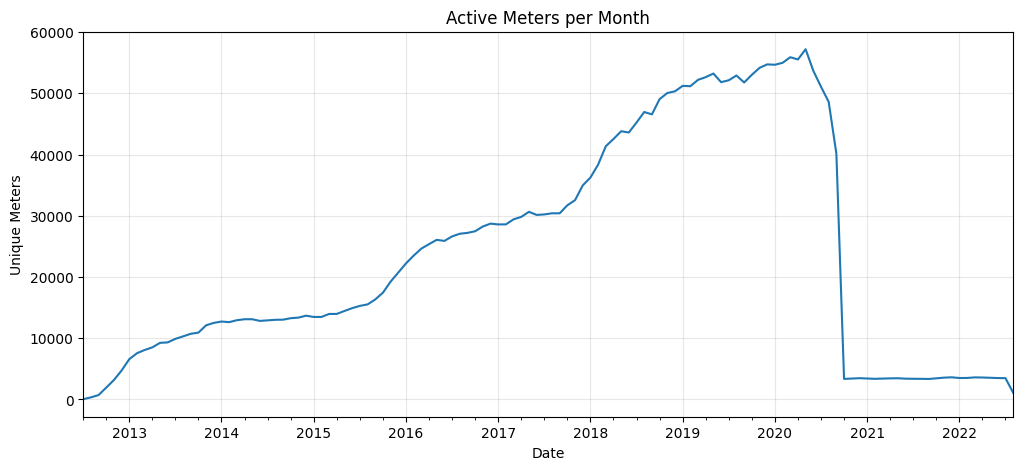

month_start
2020-09-01    40145
2020-10-01     3363
2020-11-01     3416
2020-12-01     3476
2021-01-01     3425
2021-02-01     3374
2021-03-01     3411
2021-04-01     3447
2021-05-01     3467
2021-06-01     3396
2021-07-01     3382
2021-08-01     3372
2021-09-01     3351
2021-10-01     3452
2021-11-01     3565
2021-12-01     3620
2022-01-01     3507
2022-02-01     3516
2022-03-01     3605
2022-04-01     3588
2022-05-01     3545
2022-06-01     3499
2022-07-01     3480
2022-08-01     1111
Freq: MS, Name: meterid, dtype: int64

In [27]:
active_meters_monthly = (
    monthly.groupby(monthly['month_start'].dt.to_period('M'))['meterid'].nunique()
)
active_meters_monthly.index = active_meters_monthly.index.to_timestamp()

active_meters_monthly.plot(figsize=(12,5))
plt.title("Active Meters per Month")
plt.xlabel("Date")
plt.ylabel("Unique Meters")
plt.grid(True, alpha=0.3)
plt.show()

active_meters_monthly.tail(24)  # show last 2 years as a table


In [29]:
eda_df_clean = monthly[monthly['month_start'] <= "2020-09-30"]
print("Rows kept:", len(eda_df_clean))
print("Date range:", eda_df_clean['month_start'].min(), "→", eda_df_clean['month_start'].max())


Rows kept: 2789678
Date range: 2012-07-01 00:00:00 → 2020-09-01 00:00:00


C:\Users\Asus\AppData\Local\Temp\ipykernel_7084\3341455080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df_clean['month_num'] = eda_df_clean['month_start'].dt.month


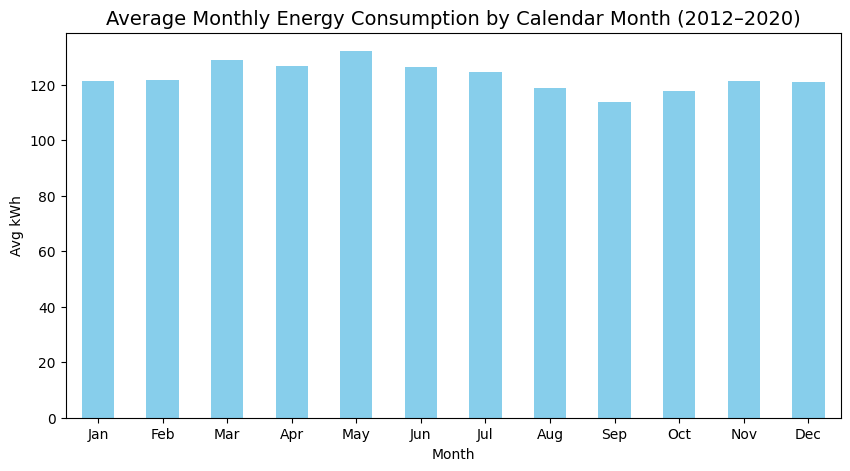

In [30]:
# Extract month of year
eda_df_clean['month_num'] = eda_df_clean['month_start'].dt.month
seasonality = eda_df_clean.groupby('month_num')['kwh'].mean()

seasonality.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Average Monthly Energy Consumption by Calendar Month (2012–2020)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Avg kWh")
plt.xticks(range(0,12), 
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], 
           rotation=0)
plt.show()


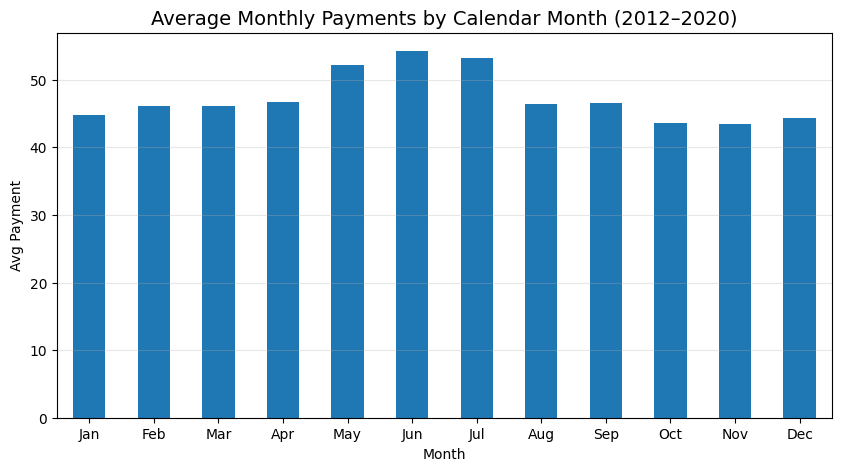

In [31]:
# Work on a safe copy to avoid SettingWithCopy warnings
eda_season = eda_df_clean.copy()
eda_season['month_num'] = eda_season['month_start'].dt.month

pay_seasonality = eda_season.groupby('month_num')['paymoney'].mean()

pay_seasonality.plot(kind='bar', figsize=(10,5))
plt.title("Average Monthly Payments by Calendar Month (2012–2020)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Avg Payment")
plt.xticks(range(0,12), 
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], 
           rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


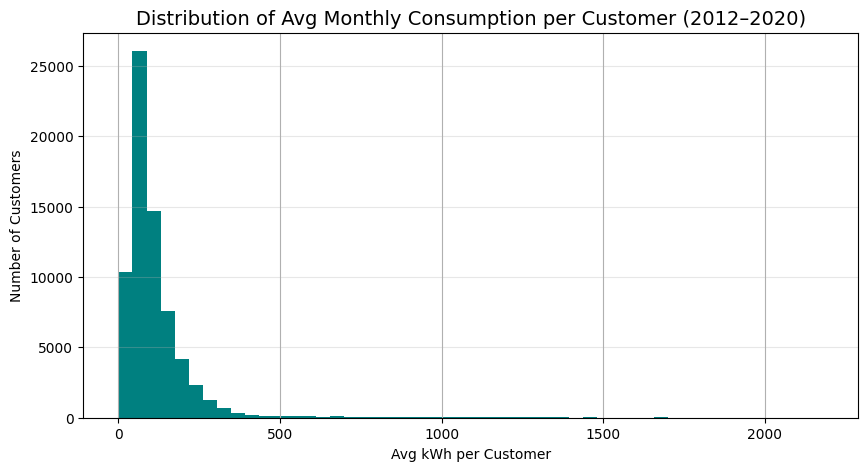

count    69027.000000
mean       115.722282
std        133.512924
min          0.000000
25%         53.632717
50%         83.339996
75%        133.781235
max       2180.208740
Name: kwh, dtype: float64

In [32]:
customer_avg_kwh = (
    eda_df_clean.groupby('meterid')['kwh'].mean()
)

customer_avg_kwh.hist(bins=50, figsize=(10,5), color='teal')
plt.title("Distribution of Avg Monthly Consumption per Customer (2012–2020)", fontsize=14)
plt.xlabel("Avg kWh per Customer")
plt.ylabel("Number of Customers")
plt.grid(axis='y', alpha=0.3)
plt.show()

customer_avg_kwh.describe()


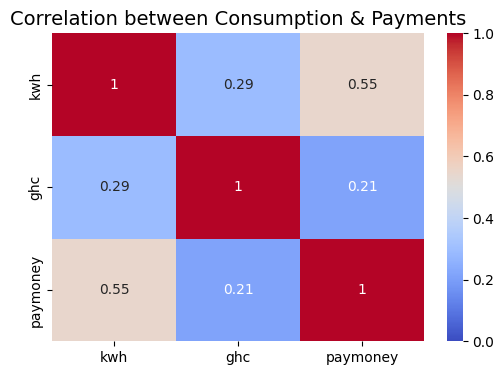

In [35]:
import seaborn as sns

corr = eda_df_clean[['kwh','ghc','paymoney']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Correlation between Consumption & Payments", fontsize=14)
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_7084\772411159.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df_clean.groupby('loc')['kwh']


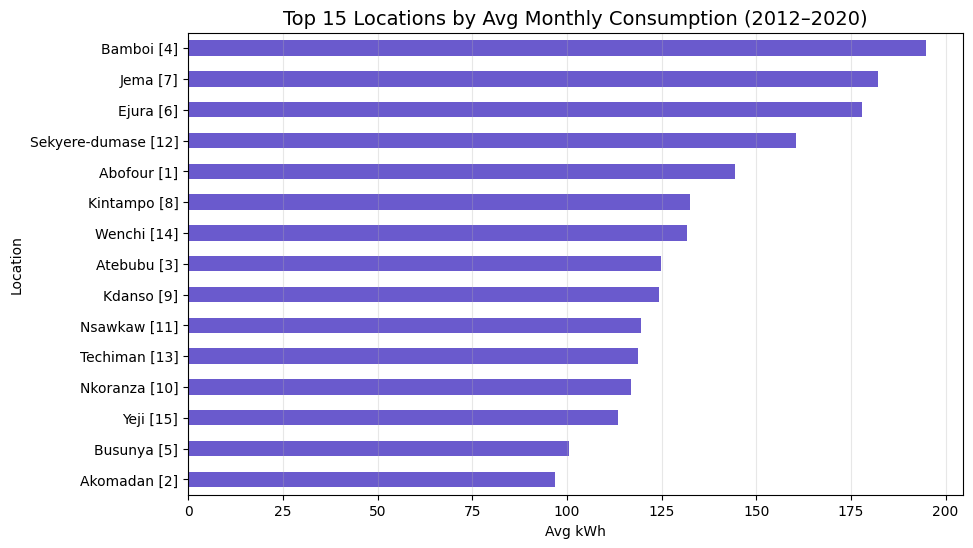

loc
Bamboi [4]             194.897919
Jema [7]               182.250290
Ejura [6]              177.828873
Sekyere-dumase [12]    160.435699
Abofour [1]            144.300812
Kintampo [8]           132.615646
Wenchi [14]            131.667480
Atebubu [3]            124.952065
Kdanso [9]             124.426811
Nsawkaw [11]           119.536362
Techiman [13]          118.776794
Nkoranza [10]          116.894424
Yeji [15]              113.530434
Busunya [5]            100.594543
Akomadan [2]            96.788063
Name: kwh, dtype: float32

In [36]:
loc_kwh = (
    eda_df_clean.groupby('loc')['kwh']
    .mean()
    .sort_values(ascending=False)
    .head(15)  # top 15 locations
)

loc_kwh.plot(kind='barh', figsize=(10,6), color='slateblue')
plt.title("Top 15 Locations by Avg Monthly Consumption (2012–2020)", fontsize=14)
plt.xlabel("Avg kWh")
plt.ylabel("Location")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.show()

loc_kwh


C:\Users\Asus\AppData\Local\Temp\ipykernel_7084\3808201040.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df_clean.groupby('res')['kwh']


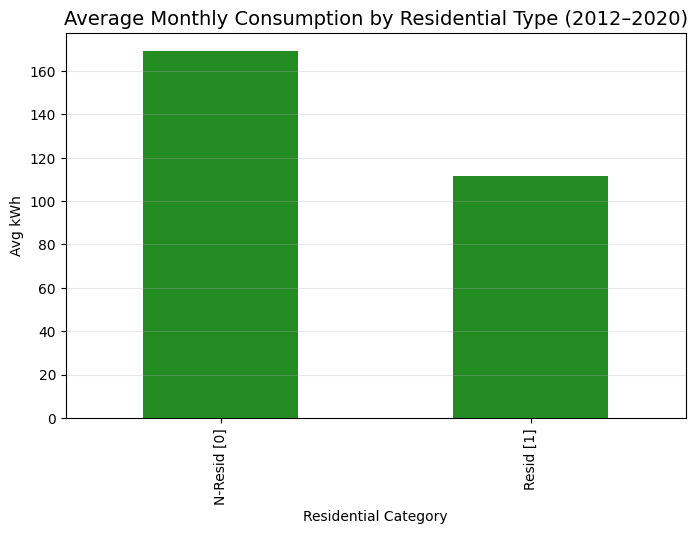

res
N-Resid [0]    169.081604
Resid [1]      111.582985
Name: kwh, dtype: float32

In [37]:
res_kwh = (
    eda_df_clean.groupby('res')['kwh']
    .mean()
    .sort_values(ascending=False)
)

res_kwh.plot(kind='bar', figsize=(8,5), color='forestgreen')
plt.title("Average Monthly Consumption by Residential Type (2012–2020)", fontsize=14)
plt.xlabel("Residential Category")
plt.ylabel("Avg kWh")
plt.grid(axis='y', alpha=0.3)
plt.show()

res_kwh


## Step 2 Conclusion: Exploratory Data Analysis (EDA)

From the exploratory analysis, we found the following key insights:

1. **Data Coverage**  
   - Data is reliable from **2012 up to September 2020**.  
   - After October 2020, the number of active meters collapsed (~65K → ~3K), so later years are incomplete.

2. **Trends Over Time**  
   - Both consumption (kWh) and payments grew steadily from 2012–2019.  
   - Peak in 2019/early 2020 before the data collapse.  

3. **Seasonality**  
   - Clear monthly patterns: higher usage and payments in **March–July**, dips in **Aug–Oct**.  
   - Indicates seasonal demand (possibly weather, economic cycles, or cultural factors).

4. **Customer Distribution**  
   - Highly skewed: most customers consume **50–130 kWh/month**, but a few exceed **2000+ kWh/month**.  
   - Long tail likely represents large businesses or industrial customers.

5. **Correlations**  
   - Payments correlate moderately with consumption (**kWh ↔ paymoney = 0.55**).  
   - Weak correlation with `ghc` values (possibly due to tariff inconsistencies or underpayments).

6. **Geographic & Category Differences**  
   - Locations like **Bamboi, Jema, Ejura** have the highest average consumption.  
   - **Non-residential customers** consume ~50% more energy than residential ones.

---

### **Implication**  
The dataset is rich and consistent (until Sep 2020), making it suitable for:  
- **Time-series forecasting** of demand and payments.  
- **Customer segmentation** (residential vs non-residential, low vs high consumers).  
- **Anomaly detection** (unusual payments vs usage).  

We will move forward to **Step 3: Feature Engineering** to prepare the dataset for modeling.


# Step 3: Feature Engineering  

In this step, we create a clean, consistent dataset for modeling.  
We will:  
- Build a **base modeling dataset** (monthly meter-level records)  
- Add **lag features** (past consumption/payments)  
- Add **rolling averages/trends** to capture customer behavior  
- Encode categorical variables (`loc`, `res`) for use in models  


In [39]:
# Step 3.1: Base modeling dataset

# Keep only relevant columns for modeling
model_df = monthly[['meterid', 'month_start', 'kwh', 'paymoney', 'loc', 'res']].copy()

# Ensure sorted by meter and time
model_df = model_df.sort_values(['meterid', 'month_start']).reset_index(drop=True)

# Quick check
model_df.head()


,meterid,month_start,kwh,paymoney,loc,res
0,1,2019-02-01,14.200000,140.0,Techiman [13],N-Resid [0]
1,1,2019-03-01,57.400002,40.0,Techiman [13],N-Resid [0]
2,1,2019-04-01,57.400002,20.0,Techiman [13],N-Resid [0]
3,1,2019-05-01,57.400002,20.0,Techiman [13],N-Resid [0]
4,1,2019-06-01,57.400002,20.0,Techiman [13],N-Resid [0]


## 3.2 Lag Features  

Lag features capture past consumption and payment behavior, helping the model detect trends.  
We will create:  
- `kwh_lag1`, `kwh_lag3`: Consumption 1 and 3 months ago  
- `pay_lag1`, `pay_lag3`: Payment 1 and 3 months ago  


In [40]:
# Step 3.2: Create lag features (past values)

# Lag features for kWh
model_df['kwh_lag1'] = model_df.groupby('meterid')['kwh'].shift(1)
model_df['kwh_lag3'] = model_df.groupby('meterid')['kwh'].shift(3)

# Lag features for payments
model_df['pay_lag1'] = model_df.groupby('meterid')['paymoney'].shift(1)
model_df['pay_lag3'] = model_df.groupby('meterid')['paymoney'].shift(3)

# Quick preview
model_df.head(10)


,meterid,month_start,kwh,paymoney,loc,res,kwh_lag1,kwh_lag3,pay_lag1,pay_lag3
0,1,2019-02-01,14.200000,140.0,Techiman [13],N-Resid [0],NaN,NaN,NaN,NaN
1,1,2019-03-01,57.400002,40.0,Techiman [13],N-Resid [0],14.200000,NaN,140.0,NaN
2,1,2019-04-01,57.400002,20.0,Techiman [13],N-Resid [0],57.400002,NaN,40.0,NaN
3,1,2019-05-01,57.400002,20.0,Techiman [13],N-Resid [0],57.400002,14.200000,20.0,140.0
4,1,2019-06-01,57.400002,20.0,Techiman [13],N-Resid [0],57.400002,57.400002,20.0,40.0
5,1,2019-07-01,50.099998,40.0,Techiman [13],N-Resid [0],57.400002,57.400002,20.0,20.0
6,1,2019-08-01,28.400000,40.0,Techiman [13],N-Resid [0],50.099998,57.400002,40.0,20.0
7,1,2019-09-01,28.400000,40.0,Techiman [13],N-Resid [0],28.400000,57.400002,40.0,20.0
8,1,2019-10-01,46.500000,40.0,Techiman [13],N-Resid [0],28.400000,50.099998,40.0,40.0
9,1,2019-11-01,36.200001,50.0,Techiman [13],N-Resid [0],46.500000,28.400000,40.0,40.0


## 3.3 Rolling Statistics (Trends)

Rolling averages smooth out fluctuations and capture short-term trends.  
We will compute:  
- 3-month rolling mean of consumption and payments  
- 6-month rolling mean of consumption  


In [43]:
# Step 3.3: Rolling averages

# Rolling averages for kWh
model_df['kwh_roll3'] = (
    model_df.groupby('meterid')['kwh']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

model_df['kwh_roll6'] = (
    model_df.groupby('meterid')['kwh']
    .transform(lambda x: x.rolling(window=6, min_periods=1).mean())
)

# Rolling averages for Payments
model_df['pay_roll3'] = (
    model_df.groupby('meterid')['paymoney']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

# Quick check
model_df.head(12)


,meterid,month_start,kwh,paymoney,loc,res,kwh_lag1,kwh_lag3,pay_lag1,pay_lag3,kwh_roll3,kwh_roll6,pay_roll3
0,1,2019-02-01,14.200000,140.0,Techiman [13],N-Resid [0],NaN,NaN,NaN,NaN,14.200000,14.200000,140.000000
1,1,2019-03-01,57.400002,40.0,Techiman [13],N-Resid [0],14.200000,NaN,140.0,NaN,35.800001,35.800001,90.000000
2,1,2019-04-01,57.400002,20.0,Techiman [13],N-Resid [0],57.400002,NaN,40.0,NaN,43.000001,43.000001,66.666667
3,1,2019-05-01,57.400002,20.0,Techiman [13],N-Resid [0],57.400002,14.200000,20.0,140.0,57.400002,46.600001,26.666667
4,1,2019-06-01,57.400002,20.0,Techiman [13],N-Resid [0],57.400002,57.400002,20.0,40.0,57.400002,48.760001,20.000000
5,1,2019-07-01,50.099998,40.0,Techiman [13],N-Resid [0],57.400002,57.400002,20.0,20.0,54.966667,48.983334,26.666667
6,1,2019-08-01,28.400000,40.0,Techiman [13],N-Resid [0],50.099998,57.400002,40.0,20.0,45.300000,51.350001,33.333333
7,1,2019-09-01,28.400000,40.0,Techiman [13],N-Resid [0],28.400000,57.400002,40.0,20.0,35.633333,46.516667,40.000000
8,1,2019-10-01,46.500000,40.0,Techiman [13],N-Resid [0],28.400000,50.099998,40.0,40.0,34.433333,44.700000,40.000000
9,1,2019-11-01,36.200001,50.0,Techiman [13],N-Resid [0],46.500000,28.400000,40.0,40.0,37.033333,41.166667,43.333333
